Just starting to think about how I can do this. 

# Collecting Stats From Previously Gathered Data

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os


In [23]:
def returnFullSeasonStats(teamName):
    """
    Goes into stats folder and reads in the both stats and Info csv files
    Concats them into a single data frame and returns them.

    Args:
        teamName (string): the team name matching the name within Stats File
        
    Returns:
        TeamPDStats: Pandas Data-Frame of team game stats from all seasons collected
        teamPDInfo: Pandas Data-Frame of game info from all seasons collected
    """
    #data frame holding things like total yards for every season collected
    teamPDStats = pd.DataFrame()
    #data frame holding things like weather for every game in every season collected
    teamPDInfo = pd.DataFrame()
    #gets all csv files for a team
    dirList = os.listdir(f"Stats/{teamName}/")
    for file in dirList:
        #if stats then --> else, it is the game info. 
        if "Stats" in file:
            curr = pd.read_csv(f"Stats/{teamName}/{file}")
            teamPDStats = pd.concat([teamPDStats, curr],axis = 0)
        else:
            curr = pd.read_csv(f"Stats/{teamName}/{file}")
            teamPDInfo = pd.concat([teamPDInfo, curr],axis = 0)
    #returns the collected, concected pds. 
    return teamPDStats, teamPDInfo
 
def returnSpecificRow(teamDataFrame, statName):
    """
    Pulls specifc rows from a given dataframe with given stat name

    Args:
        statName (string): the name of stat within the dataframe
        teamDataFrame (Pandas Data Fram): Passed dataframe containing all of the
    Returns:
        statPD: Dataframe of row querried for
    """
    statPD = pd.DataFrame(teamDataFrame.loc[teamDataFrame["Unnamed: 1"] == statName, "Game0": "Game16"].values.flatten())
    return statPD

def extractNumberFromString(givenString):
    """
    Extracts a float from a string with a format. Requires this number to have a decimal point

    Args:
        givenString (string): string with number inside
    Returns:
        extractedFloat (float): the extracted number within the string
    """
    extractedFloat = givenString.extract(r"(\d+\.\d*)").astype(float)
    return extractedFloat


In [21]:
#directory where Stats was stored
directory = 'Stats/'

yearArr = [2018, 2019, 2020, 2021, 2022, 2023]

#array of each directory within stats
TeamNamesArr= os.listdir(directory)

for team in TeamNamesArr:
    if team == ".DS_Store":
        continue
    currFullSeasonStats, currFullSeasonInfo = returnFullSeasonStats(team)

    #geting team scores and opp scores
    teamsScore = returnSpecificRow(currFullSeasonStats, "DEN Score")
    opponentScore = returnSpecificRow(currFullSeasonStats, "Opp Score")

    #getting total score
    totalScore = teamsScore[0].astype(float) + opponentScore[0].astype(float)

    #getting actual spread
    realSpread = teamsScore[0].astype(float) - opponentScore[0].astype(float)
    
    #getting vegas over under
    overUnder = returnSpecificRow(currFullSeasonInfo, "Over/Under")

    #getting vegas spread
    spread = returnSpecificRow(currFullSeasonInfo, "Vegas Line")


    
    #This takes the pandas array, with info like "45.5 (over)" and takes just the number
    #extract takes a regular exprexsion (regex) "\d" grabs number before decimal place
    #"/.?" grabs the the decimal point and "\d*" grabs the post decimal place. 
    #() tells .extract to only take what is in the parentheses until white space.
    
    overUnderNumber = extractNumberFromString(overUnder[0].str)
    spreadNumber =  extractNumberFromString(spread[0].str)

    #convering spread to be in format as vegas. 
    for i in range(len(realSpread)):
        if ("nan" not in str(spread[0][i])) and team not in spread[0][i]:
            #if broncos were favored then switch there real spread to reflect they won
            #locate the row i in first column make it negative. 
            spreadNumber.iloc[i, 0] = -1 * spreadNumber.iloc[i, 0]


    currBeatSpread = realSpread - spreadNumber
    break
    

print(overUnderNumber)



        0
0    44.5
1    45.5
2    44.5
3    45.5
4    42.0
..    ...
97   42.5
98   43.0
99   40.0
100  41.5
101   NaN

[102 rows x 1 columns]


## When the actual spread wins, it means the current team of interest beat the spread

Dont love current implementation, need to think further about how I want to visualize when current team of interest is the underdog vs favored. As it stands, I changed the actual game score difference (team of interest - opponent team) to be negative if they were favored. 

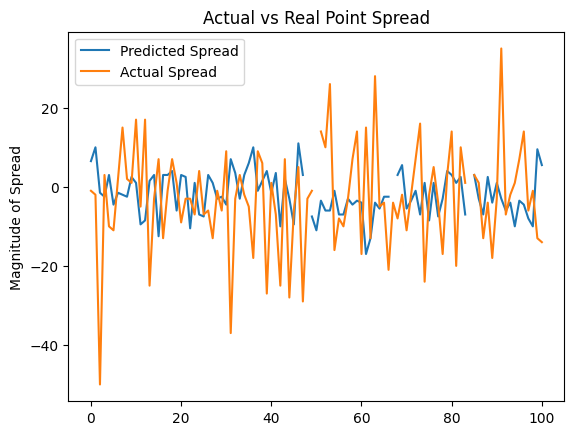

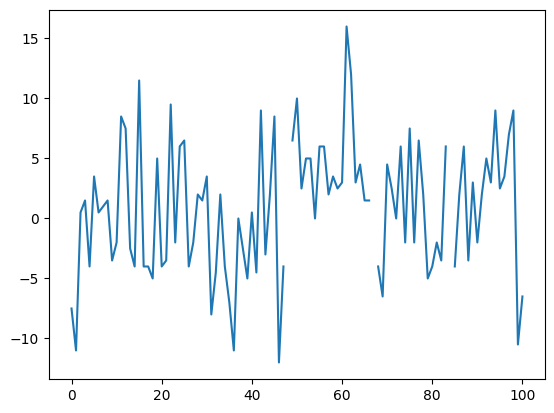

In [22]:
plt.plot(spreadNumber, label = "Predicted Spread")
plt.plot(realSpread, label = "Actual Spread")
plt.title("Actual vs Real Point Spread")
plt.ylabel("Magnitude of Spread")
plt.legend()



plt.figure(2)
plt.plot(currBeatSpread)

In [5]:
spreadNumber

,0
0,-6.5
1,-10.0
2,1.5
3,2.5
4,-3.0
...,...
97,8.0
98,10.0
99,-9.5
100,-5.5


In [6]:
currFullSeasonStats["Unnamed: 1"].head(16)

0         Cmp-Att-Yd-TD-INT
1                 DEN Score
2               First Downs
3         Fourth Down Conv.
4              Fumbles-Lost
5                  HomeTeam
6            Net Pass Yards
7                 Opp Score
8     Opp_Cmp-Att-Yd-TD-INT
9           Opp_First Downs
10    Opp_Fourth Down Conv.
11         Opp_Fumbles-Lost
12       Opp_Net Pass Yards
13      Opp_Penalties-Yards
14         Opp_Rush-Yds-TDs
15         Opp_Sacked-Yards
Name: Unnamed: 1, dtype: object

In [7]:
currFullSeasonInfo["Unnamed: 1"].head(9)

0     Attendance
1       Duration
2     Over/Under
3           Roof
4        Surface
5     Vegas Line
6        Weather
7    Won OT Toss
8       Won Toss
Name: Unnamed: 1, dtype: object

In [8]:
for i in range(65, 69):
    if ("nan" not in str(spread[0][i])):
        print(f"{spread[0][i]} is number")
    else:
        print(f"{spread[0][i]} is nan")

Los Angeles Chargers -2.5 is number
Las Vegas Raiders -2.5 is number
nan is nan
Denver Broncos -3.0 is number


0       16
1       33
2       20
3       31
4       21
      ... 
97      14
98      16
99      14
100      9
101    NaN
Name: 0, Length: 102, dtype: object

In [87]:
spread[0].str.extract(r"(\d+\.\d*)").astype(float)


,0
0,6.5
1,10.0
2,1.5
3,2.5
4,3.0
...,...
97,8.0
98,10.0
99,9.5
100,5.5
